<a href="https://colab.research.google.com/github/martinpius/DEEP-CNN-TRANSFER/blob/main/Save_and_loading_models%2C_transfer_learning_with_pre_trained_tf_keras_and_tf_hub_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using google CoLab with tensonsrflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n...please load your drive...")
  COLAB = False
def time_fmt(t:float = 231.9202)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
print(f"\n...formating the excecution time...formating the excecution time...formating...\n<<<<time elapse>>>: {time_fmt()}")

Mounted at /content/drive
You are using google CoLab with tensonsrflow version: 2.4.1

...formating the excecution time...formating the excecution time...formating...
<<<<time elapse>>>: 0: 03: 51.00


In [2]:
import time, os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train.astype(np.float32)/255.0, x_test.astype(np.float32)/255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train, num_classes = 10), tf.keras.utils.to_categorical(y_test, num_classes = 10)
print(f"x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}\nx_test_shape: {x_test.shape},y_test_shape: {y_test.shape}")

170500096/170498071 [==============================] - 11s 0us/step
x_train_shape: (50000, 32, 32, 3), y_train_shape: (50000, 10)
x_test_shape: (10000, 32, 32, 3),y_test_shape: (10000, 10)


Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 32, 32, 64)        256       
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 32, 256)       295168    
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 32, 32, 256)       1

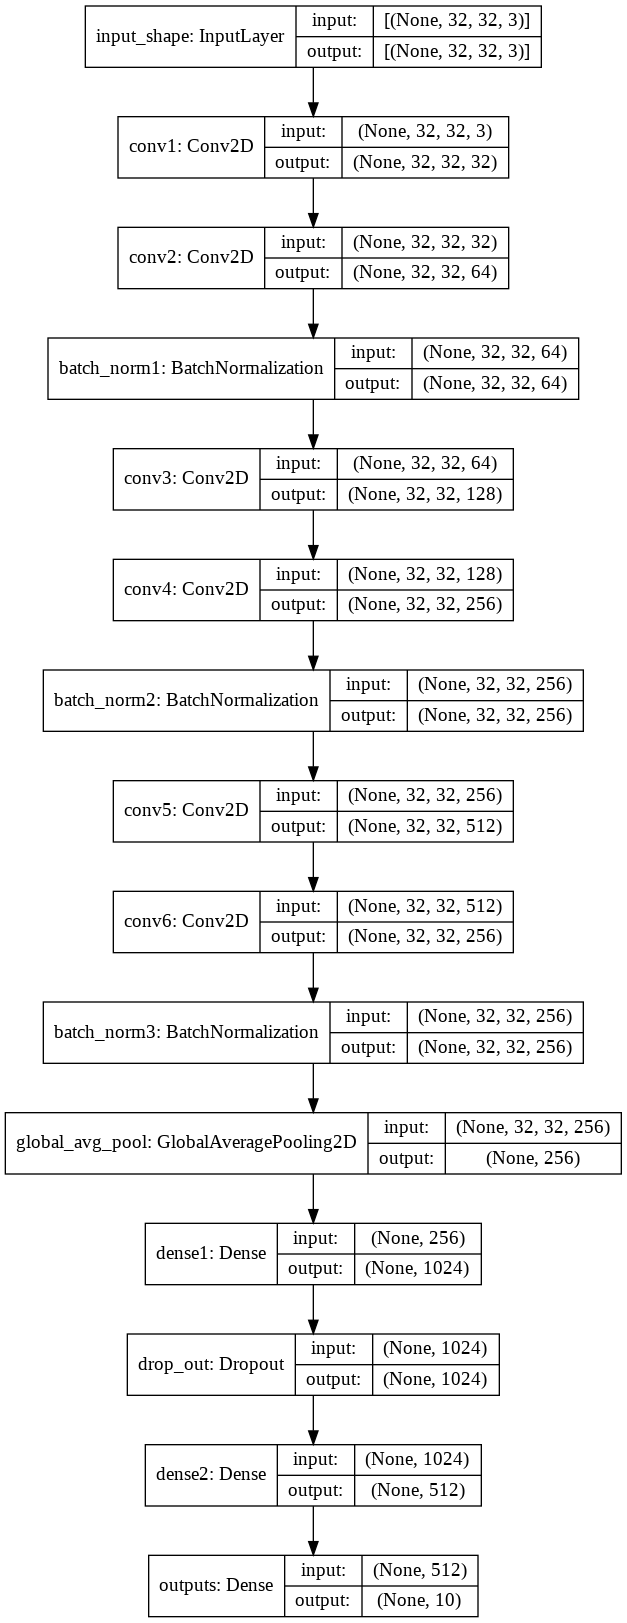

In [4]:
#Train a simple  CNN
inputs = tf.keras.Input(shape = (32,32,3), name = 'input_shape')
x = tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (3,3), 
                           padding = 'same', 
                           strides = (1,1),
                           kernel_initializer = 'random_normal',
                           activation = 'relu',
                           name = 'conv1')(inputs)
x = tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3),
                           padding = 'same',
                           strides = (1,1),
                           activation = 'relu',
                           name = 'conv2')(x)
x = tf.keras.layers.BatchNormalization(name = 'batch_norm1')(x)
x = tf.keras.layers.Conv2D(filters = 128, 
                           kernel_size = (3,3),
                           padding = 'same',
                           strides = (1,1),
                           activation = 'relu',
                           name = 'conv3')(x)
x = tf.keras.layers.Conv2D(filters = 256,
                           kernel_size = (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           name = 'conv4')(x)
x = tf.keras.layers.BatchNormalization(name = 'batch_norm2')(x)
x = tf.keras.layers.Conv2D(filters = 512,
                           kernel_size = (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           name = 'conv5')(x)
x = tf.keras.layers.Conv2D(filters = 256,
                           kernel_size = (3,3),
                           strides = (1,1),
                           padding = 'same',
                           activation = 'relu',
                           name = 'conv6')(x) 
x = tf.keras.layers.BatchNormalization(name = 'batch_norm3')(x)  
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_avg_pool')(x)  
x = tf.keras.layers.Dense(units = 1024, activation = 'relu', name = 'dense1')(x)
x = tf.keras.layers.Dropout(rate = 0.25, name = 'drop_out')(x)
x = tf.keras.layers.Dense(units = 512, activation = 'relu', name = 'dense2')(x)
outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'outputs')(x)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'simple_cnn')
model.summary()
tf.keras.utils.plot_model(model = model, to_file = 'simple_cnn.png', show_shapes = True)                                                 


      

In [6]:
tic = time.time()
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam', metrics = ['accuracy'])
model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 64, verbose = 2, epochs = 3)
toc = time.time()
print(f"\ntime elapse: {time_fmt(toc - tic)}")

Epoch 1/3
782/782 - 175s - loss: 1.0407 - accuracy: 0.6278 - val_loss: 1.1652 - val_accuracy: 0.5936
Epoch 2/3
782/782 - 171s - loss: 0.8059 - accuracy: 0.7138 - val_loss: 1.0364 - val_accuracy: 0.6332
Epoch 3/3
782/782 - 171s - loss: 0.6637 - accuracy: 0.7686 - val_loss: 0.7456 - val_accuracy: 0.7455

time elapse: 0: 08: 37.00


In [7]:
#Saving and re-loading the model
model.save('my_cnn')

INFO:tensorflow:Assets written to: my_cnn/assets


In [8]:
new_model = tf.keras.models.load_model('my_cnn')

In [9]:
new_model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_norm1 (BatchNormalizat (None, 32, 32, 64)        256       
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 32, 256)       295168    
_________________________________________________________________
batch_norm2 (BatchNormalizat (None, 32, 32, 256)       1

In [10]:
#We can do transfer learning in multiple ways:
#Lets exclude the output layer and train the same model on new data with different outputs

In [17]:
base_outputs = new_model.layers[-2].output #grab the all layers except the last
base_inputs = new_model.layers[0].input #grab the input layer of original model
new_outputs = tf.keras.layers.Dense(units = 10, activation = 'softmax', name = 'new_outputs')(base_outputs) #constructing new output layer
 #Lets build our new model to classify on 10 dataset with 10 classes(so we may use the same data for demo)
trf_model = tf.keras.Model(inputs = base_inputs, outputs = new_outputs)
trf_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'RMSprop', metrics = ['accuracy'])
trf_model.trainable = False # to save time We may not need to train the layers again
for layer in trf_model.layers:
  assert layer.trainable == False
tic = time.time()
trf_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, verbose = 2, batch_size = 64)
trf_model.summary()
tf.keras.utils.plot_model(model = trf_model, to_file = 'trf_model.png', show_shapes = True)
toc = time.time()
print(f"....Total time for training and evaluation is....\ntime elapse: {time_fmt(toc - tic)}")

Epoch 1/10
782/782 - 59s - loss: 0.5979 - accuracy: 0.7998 - val_loss: 0.6544 - val_accuracy: 0.7765
Epoch 2/10
782/782 - 59s - loss: 0.5337 - accuracy: 0.8146 - val_loss: 0.6480 - val_accuracy: 0.7775
Epoch 3/10
782/782 - 59s - loss: 0.5275 - accuracy: 0.8166 - val_loss: 0.6421 - val_accuracy: 0.7848
Epoch 4/10
782/782 - 59s - loss: 0.5256 - accuracy: 0.8172 - val_loss: 0.6399 - val_accuracy: 0.7862
Epoch 5/10
782/782 - 59s - loss: 0.5225 - accuracy: 0.8193 - val_loss: 0.6438 - val_accuracy: 0.7829
Epoch 6/10
782/782 - 59s - loss: 0.5205 - accuracy: 0.8190 - val_loss: 0.6420 - val_accuracy: 0.7860
Epoch 7/10
782/782 - 58s - loss: 0.5204 - accuracy: 0.8201 - val_loss: 0.6484 - val_accuracy: 0.7839
Epoch 8/10
782/782 - 58s - loss: 0.5182 - accuracy: 0.8203 - val_loss: 0.6480 - val_accuracy: 0.7847
Epoch 9/10
782/782 - 58s - loss: 0.5188 - accuracy: 0.8204 - val_loss: 0.6508 - val_accuracy: 0.7858
Epoch 10/10
782/782 - 58s - loss: 0.5177 - accuracy: 0.8212 - val_loss: 0.6478 - val_accura

In [18]:
#Transfer leraning from inbuilt keras model:
#There are multiple models included in keras API.
#We may load these models and modifly to suit our own need

In [19]:
#An example on inceptionV3 model:

In [31]:
model = tf.keras.applications.InceptionV3(include_top = True)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [32]:
#The input of this model are images of shape (229,229 3):
#We can preprocess our new images to suit that criteria and perform the transfer learning accordingly: 

In [33]:
base_inputs = model.layers[0].input
base_outputs = model.layers[-2].output
new_outputs = tf.keras.layers.Dense(units = 5, name = 'new_outputs')(base_outputs)
inception_turned = tf.keras.Model(inputs = base_inputs, outputs = new_outputs, name = 'turned_inception')
inception_turned.summary()

Model: "turned_inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
___________________________________________________________________________________

In [39]:
#inception_turned.trainable = False #We do not train the layers again(the pretrained weights will be used)
x_train = tf.random.normal(shape = (10, 299,299,3)) #10 fake images
y_train = tf.constant([0,1,2,3,4,2,4,3,0,1]) #10 fake labels
x_test = tf.random.normal(shape = (5, 299,299,3)) #5 fake images
y_test = tf.constant([0,1,2,3,4]) #5 fake labels
inception_turned.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'Adam', metrics = ['accuracy'])
tic = time.time()
inception_turned.fit(x_train, y_train, verbose = 2, epochs = 3)
toc = time.time()
print(f"\ntime elapse: {time_fmt(toc - tic)}")

Epoch 1/3
1/1 - 8s - loss: 3.4117 - accuracy: 0.2000
Epoch 2/3
1/1 - 0s - loss: 0.7042 - accuracy: 0.8000
Epoch 3/3
1/1 - 0s - loss: 0.3545 - accuracy: 1.0000

time elapse: 0: 00: 08.00


In [40]:
#We can also import model with pretrained weights from tensorflow-hub using the url 

In [45]:
x = tf.random.normal(shape = (5, 299,299,3))
y = tf.constant([0,1,2,3,4])
#We import the model from tensorflow-hub and build the model to train data with classes of our choice
url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
myhub_model = hub.KerasLayer(url, input_shape = (299,299,3))
#From the base model we can add more layer sequentially to suit our needs
model = tf.keras.Sequential(
    [
     myhub_model,
     tf.keras.layers.Dense(units = 128, activation = 'relu'),
     tf.keras.layers.Dense(units = 64, activation = 'relu'),
     tf.keras.layers.Dense(units = 5)
    ]
)
tic = time.time()
model.summary()
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
              optimizer = 'Adam', metrics = ['accuracy'])
model.trainable = False
model.fit(x,y, verbose = 2, epochs = 10)
toc = time.time()
print(f"\ntime elapse: {time_fmt(toc - tic)}")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 325       
Total params: 22,073,637
Trainable params: 270,853
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/10
1/1 - 6s - loss: 1.6411 - accuracy: 0.2000
Epoch 2/10
1/1 - 0s - loss: 1.5305 - accuracy: 0.2000
Epoch 3/10
1/1 - 0s - loss: 1.3847 - accuracy: 0.6000
Epoch 4/10
1/1 - 0s - loss: 1.2673 - accuracy: 0.8000
Epoch 5/10
1/1 - 0